# Font Finder

## Install packages

In [1]:
!pip3 install torch torchvision torchsummary pytorch-lightning

    2% |▊                               | 17.3MB 5.5MB/s eta 0:02:15^C

Operation cancelled by user


## H5PY Dataset

In [40]:
from torch.utils.data import Dataset
from torchvision.transforms.functional import to_tensor
import h5py
import torch

class CustomDataset(Dataset):

    def __init__(self, filepath='datasets.hdf5', group='train'):
        self.file = h5py.File(filepath, 'r')
        self.class_num = self.file.attrs['class_num']
        self.group = self.file[group]
        self.length = len(self.group['data'])
        self.current = 0

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        data = self.group['data'][idx]
        label = self.group['labels'][idx]
        return (to_tensor(data), label.astype('i8'))

    def __iter__(self):
        return self

    def __next__(self):
        if self.current < self.length:
            item = self.__getitem__(self.current)
            self.current += 1
            return item
        raise StopIteration

    def close(self):
        self.file.close()

## Class Names

In [41]:
class_names = [
    'Ubuntu-Regular',
    'PlayfairDisplay-Regular',
    'PTAstraSans-Regular',
    'PT Astra Serif_Regular',
    'Akrobat-Regular',
    'Golos Text_Regular',
    'MontserratAlternates-Regular',
    'Roboto-Regular',
    'Gravity-Regular',
    'Inter-Regular',
    'SourceSansPro-Regular',
    'EBGaramond-Regular',
    'NotoSans-Regular',
    'LiberationSerif-Regular',
    'OpenSans-Regular',
    'Merriweather-Regular',
    'Arsenal-Regular',
    'PlayfairDisplaySC-Regular',
    'IBMPlexSerif-Regular',
    'NotoSerif-Regular',
    'PT Root UI_Regular',
    'Lora-Regular',
    'LiberationMono-Regular',
    'Sansation_Regular',
    'Montserrat-Regular',
    'Alegreya-Regular',
    'Spectral-Regular',
    'IdealistSans-Regular',
    'LiberationSans-Regular',
    'Literata-Regular',
    'PTSans-Regular',
    'IBMPlexSans-Regular',
    'FiraSans-Regular',
    'UbuntuMono-Regular',
    'Sreda-Regular',
    'Oswald-Regular',
    'Phenomena-Regular',
    'Colus-Regular',
    'BebasNeue-Regular',
    'CormorantGaramond-Regular',
    'NEXT ART_Regular',
    'UbuntuCondensed-Regular'
]

## Test dataset

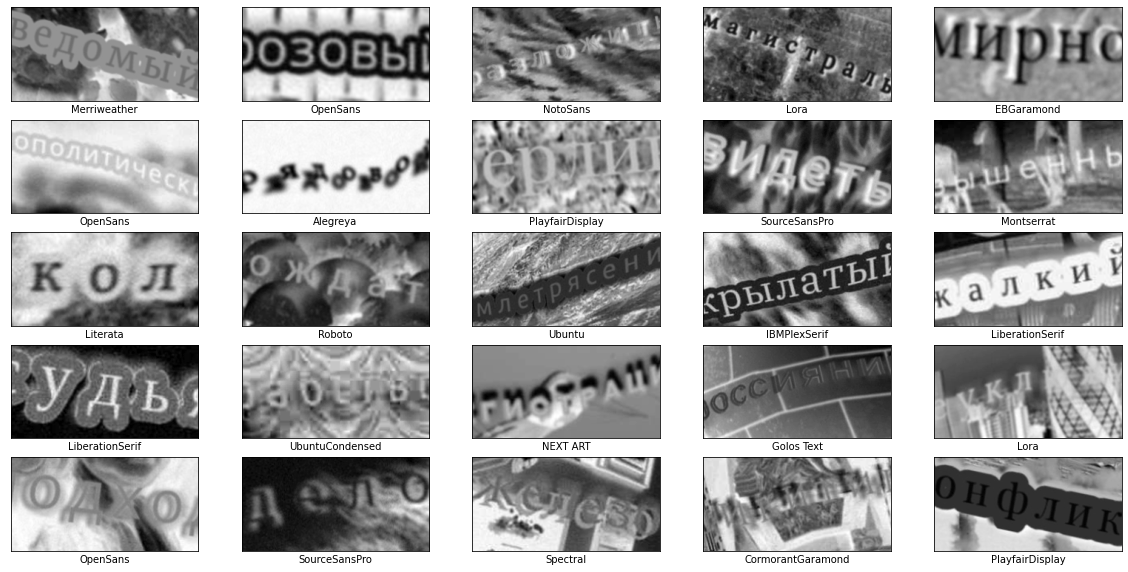

In [42]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import random as rnd

dataset = CustomDataset('../datasets/dataset_254.hdf5')

plt.figure(figsize=(20, 10))
for i in range(25):
    data, label = dataset[rnd.randint(0, len(dataset) - 1)]
    image = to_pil_image(data)
    label = class_names[label][:-len('-regular')]
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(label)
plt.show()
dataset.close()

## Model

In [43]:
import torch
import torch.nn as nn
import torch.nn.init as init
from torch.hub import load_state_dict_from_url
from pytorch_lightning import LightningModule
import torch.nn.functional as F

class Fire(nn.Module):

    def __init__(self, inplanes, squeeze_planes, expand_planes):
        super(Fire, self).__init__()
        #self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand_planes // 2, kernel_size=1)
        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand_planes // 2, kernel_size=3, padding=1)
        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.squeeze_activation(self.squeeze(x))
        return torch.cat([
            self.expand1x1_activation(self.expand1x1(x)),
            self.expand3x3_activation(self.expand3x3(x))
        ], 1)


class SqueezeNet(LightningModule):

    def __init__(self, hparams):
        super(SqueezeNet, self).__init__()
        self.hparams = hparams
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            Fire(64, 16, 128),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            Fire(128, 32, 256),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            Fire(256, 48, 384),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            Fire(384, 64, 512),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            Fire(512, 80, 640),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            Fire(640, 96, 768),
        )

        # Final convolution is initialized differently from the rest
        final_conv = nn.Conv2d(768, self.hparams.num_classes, kernel_size=1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            final_conv,
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m is final_conv:
                    init.normal_(m.weight, mean=0.0, std=0.01)
                else:
                    init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return torch.flatten(x, 1)

    def training_step(self, batch, batch_idx):
        data, target = batch
        output = self.forward(data)
        loss = F.cross_entropy(output, target)

        return { 'loss': loss }

    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        print(f'Train loss: {self.avg_train_loss}')

    def validation_step(self, batch, batch_idx):
        data, target = batch
        output = self.forward(data)
        loss = F.cross_entropy(output, target)
        pred = output.argmax(dim=1, keepdim=True)
        num_correct = pred.eq(target.view_as(pred)).sum()
        return { 'val_loss': loss, 'num_correct': num_correct }

    def validation_epoch_end(self, outputs):

        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_accuracy = torch.stack([x['num_correct'] for x in outputs]).sum().float()
        avg_accuracy /= (len(outputs) * self.hparams.batch_size)

        print(f'Val loss: {avg_loss} acc: {avg_accuracy}')
        
        return {'val_loss': avg_loss, 'val_acc': avg_accuracy }

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.hparams.learning_rate)
        #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, verbose=True)
        return [ optimizer ]#, [ scheduler ]

## Test model

In [44]:
from torchsummary import summary
import argparse
hparams = argparse.Namespace()
hparams.num_classes = 42

model = SqueezeNet(hparams)
#print(model)
summary(model, (1, 127, 254), -1, 'cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 63, 126]             640
              ReLU-2          [-1, 64, 63, 126]               0
            Conv2d-3          [-1, 16, 63, 126]           1,040
              ReLU-4          [-1, 16, 63, 126]               0
            Conv2d-5          [-1, 64, 63, 126]           1,088
              ReLU-6          [-1, 64, 63, 126]               0
            Conv2d-7          [-1, 64, 63, 126]           9,280
              ReLU-8          [-1, 64, 63, 126]               0
              Fire-9         [-1, 128, 63, 126]               0
        MaxPool2d-10          [-1, 128, 31, 63]               0
           Conv2d-11           [-1, 32, 31, 63]           4,128
             ReLU-12           [-1, 32, 31, 63]               0
           Conv2d-13          [-1, 128, 31, 63]           4,224
             ReLU-14          [-1, 128,

## Train

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer

hparams.batch_size = 16
hparams.learning_rate = 1

checkpoint_callback = ModelCheckpoint(
    '../saves/squeezenet',
    monitor='val_acc',
    save_top_k=10
)

kwargs = {'num_workers': 6, 'pin_memory': True}

train_loader = DataLoader(
    CustomDataset('../datasets/dataset_254.hdf5'),
    batch_size=hparams.batch_size, shuffle=True, #**kwargs
)
val_loader   = DataLoader(
    CustomDataset('../datasets/dataset_381.hdf5'),
    batch_size=hparams.batch_size, shuffle=False, #**kwargs
)

trainer = Trainer(
    gpus=1,
    checkpoint_callback=checkpoint_callback,
    auto_lr_find=True,
    #resume_from_checkpoint='saves/main/epoch=45.ckpt'
)
trainer.fit(model, train_loader, val_loader)